# neural network

### Import libraries

In [1]:
import sys, os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import copy

In [3]:
from src.neural_network import utils
from src.neural_network import mlp
from torchvision import models

### Configuration

In [4]:
#
# cpu or gpu
#
#device= torch.device("cuda")
device= torch.device("cpu")
print(device)

#
# net
#
net = models.resnet18(num_classes=100)
#net = models.alexnet(num_classes=100)
#net = models.vgg19(num_classes=100)
# TODO: bn is not working, figure out why
#net = models.vgg19_bn(num_classes=100)
#net = models.squeezenet1_0(num_classes=100)
#net = models.densenet161(num_classes=100)
#net = models.inception_v3(num_classes=100)
#net = models.googlenet(num_classes=100)
#net = models.shufflenet_v2_x1_0(num_classes=100)
#net = models.mobilenet_v2(num_classes=100)
#net = models.resnext50_32x4d(num_classes=100)
#net = models.wide_resnet50_2(num_classes=100)
#net = models.mnasnet1_0(num_classes=100)

#
# dataset
#
train_dataset = "./wiki_crop"
test_dataset = "./wiki_crop_test"
![ ! -d wiki_crop ] && tar xf wiki_crop.tar

# img resolution we resize to
img_pixels = (256,256)

#
# training detail
# CONFIRM: whether lr is dynamically determined by pytorch
lr = 0.01
num_epochs = 2
batch_size = 20

#
# misc
#
#print(net)
#utils.display_num_param(net)

cpu


### Setting train & eval & test dataset

In [5]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(img_pixels),
    transforms.ToTensor()])

img_data_train = torchvision.datasets.ImageFolder(root=train_dataset, transform=transform)
#print(len(img_data))
data_loader_train = torch.utils.data.DataLoader(img_data_train, batch_size=batch_size,shuffle=True)
#print(len(data_loader))

img_data_val = torchvision.datasets.ImageFolder(root=test_dataset, transform=transform)
data_loader_val = torch.utils.data.DataLoader(img_data_val, batch_size=batch_size,shuffle=True)

img_data_test = torchvision.datasets.ImageFolder(root=test_dataset, transform=transform)
data_loader_test = torch.utils.data.DataLoader(img_data_test, batch_size=1,shuffle=True)

dataloaders = {}
dataloaders['train'] = data_loader_train
dataloaders['val'] = data_loader_val

### Helper function to training

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()
    time_elapsed = since

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            time_elapsed = time.time() - time_elapsed
            
            print('{} Loss: {:.4f} Acc: {:.4f} Time: {:.0f}m {:.0f}s'.format(phase, epoch_loss, epoch_acc, time_elapsed // 60, time_elapsed % 60))

            # deep copy the modeltopk
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

### Training

In [7]:
net = net.to(device)
criterion = nn.CrossEntropyLoss()
# use ADAM, better than SGD
optimizer=torch.optim.Adam( net.parameters() , lr )
net, val_acc_history = train_model(net, dataloaders, criterion, optimizer, num_epochs)

Epoch 0/1
----------
train Loss: 8.4848 Acc: 0.0000 Time 0m 12s
val Loss: 258319712.0000 Acc: 0.1000 Time 26209651m 55s

Epoch 1/1
----------
train Loss: 5.6716 Acc: 0.0135 Time 0m 24s
val Loss: 29585964.0000 Acc: 0.0000 Time 26209651m 55s

Training complete in 0m 25s
Best val Acc: 0.100000


### Evaluation on test data

In [38]:
import numpy as np
def show_prob_age(label, p):

    p=p.data.squeeze().numpy()

    ft=15
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)

    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', #verticalalitopkgnment='center',
                 transform=ax.transData, color= col,fontsize=ft)

    plt.show()


torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
tensor([2.4176e+08, 2.3101e+08, 2.3038e+08], grad_fn=<TopkBackward>) [9, 73, 34]


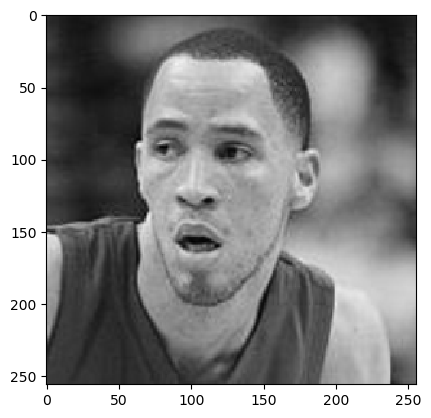

ValueError: Image size of 2045998149x389 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

In [39]:
from matplotlib import pyplot as plt

# switch to eval mode
net.eval()

# display tensor
for input, label in data_loader_test:
    print(input.size())
    image = torch.tensor(input.tolist()[0])
    trans = transforms.ToPILImage()
    print(image.size())
    plt.imshow(trans(image))
    output = net(input)
    top10 = torch.topk(output[0], 3)
    top10value = top10.values
    top10ages = top10.indices.tolist()
    print(top10value, top10ages)
    show_prob_age(top10ages, top10value.cpu())
    break